<a href="https://colab.research.google.com/github/idiftech2010/Ethical-Implications-Framework/blob/main/AICybersecurityFramework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Upload files manually
uploaded = files.upload()


Saving UNSW_NB15_testing-set.csv to UNSW_NB15_testing-set.csv
Saving UNSW_NB15_training-set.csv to UNSW_NB15_training-set.csv


In [2]:
import pandas as pd

# Load the datasets
df_train = pd.read_csv("UNSW_NB15_training-set.csv")
df_test = pd.read_csv("UNSW_NB15_testing-set.csv")

# Display basic info
print("Training Set Shape:", df_train.shape)
print("Testing Set Shape:", df_test.shape)

# Show first few rows
df_train.head()


Training Set Shape: (175341, 45)
Testing Set Shape: (82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
from sklearn.preprocessing import StandardScaler

# Drop the 'id' column if it exists
df_train.drop(columns=['id'], errors='ignore', inplace=True)
df_test.drop(columns=['id'], errors='ignore', inplace=True)

# Identify categorical and numerical columns
categorical_features = ['proto', 'service', 'state', 'attack_cat']
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in categorical_features + ['label']]

# One-Hot Encode categorical features
df_train_encoded = pd.get_dummies(df_train, columns=categorical_features)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_features)

# Align test set columns with training set
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

# Standardize numerical features
scaler = StandardScaler()
df_train_encoded[numerical_features] = scaler.fit_transform(df_train_encoded[numerical_features])
df_test_encoded[numerical_features] = scaler.transform(df_test_encoded[numerical_features])

# Verify preprocessing
print("Preprocessed Training Set Shape:", df_train_encoded.shape)
print("Preprocessed Testing Set Shape:", df_test_encoded.shape)

df_train_encoded.head()


Preprocessed Training Set Shape: (175341, 205)
Preprocessed Testing Set Shape: (82332, 205)


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat_Analysis,attack_cat_Backdoor,attack_cat_DoS,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_Shellcode,attack_cat_Worms
0,-0.191029,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,1.578100,-0.389897,-0.273700,...,False,False,False,False,False,False,True,False,False,False
1,-0.109485,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,1.560002,-0.389928,-0.069233,...,False,False,False,False,False,False,True,False,False,False
2,0.040699,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,1.560002,-0.389964,-0.252044,...,False,False,False,False,False,False,True,False,False,False
3,0.049729,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,1.560002,-0.389958,-0.275821,...,False,False,False,False,False,False,True,False,False,False
4,-0.140417,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,1.560002,-0.389927,-0.275561,...,False,False,False,False,False,False,True,False,False,False


In [4]:
from sklearn.model_selection import train_test_split

# Define feature matrix (X) and target variable (y)
X = df_train_encoded.drop(columns=['label'])
y = df_train_encoded['label']

# Split into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify split
print("Training Set Shape:", X_train.shape, y_train.shape)
print("Validation Set Shape:", X_val.shape, y_val.shape)


Training Set Shape: (140272, 204) (140272,)
Validation Set Shape: (35069, 204) (35069,)


In [5]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 20 most relevant features using ANOVA F-test
k_best = SelectKBest(score_func=f_classif, k=20)
X_train_selected = k_best.fit_transform(X_train, y_train)
X_val_selected = k_best.transform(X_val)

# Get selected feature names
selected_feature_names = X.columns[k_best.get_support()].tolist()
print("Selected Features:", selected_feature_names)

# Verify shape after feature selection
print("Reduced Training Set Shape:", X_train_selected.shape)
print("Reduced Validation Set Shape:", X_val_selected.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [192 193 200] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected Features: ['rate', 'sttl', 'dload', 'swin', 'stcpb', 'dtcpb', 'dwin', 'dmean', 'ct_state_ttl', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_ltm', 'proto_tcp', 'state_CON', 'state_FIN', 'state_INT', 'attack_cat_Exploits', 'attack_cat_Generic', 'attack_cat_Normal']
Reduced Training Set Shape: (140272, 20)
Reduced Validation Set Shape: (35069, 20)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train model
rf_model.fit(X_train_selected, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val_selected)

# Evaluate performance
rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_report = classification_report(y_val, y_pred_rf)

print("Random Forest Accuracy:", rf_accuracy)
print("Classification Report:\n", rf_report)


Random Forest Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11200
           1       1.00      1.00      1.00     23869

    accuracy                           1.00     35069
   macro avg       1.00      1.00      1.00     35069
weighted avg       1.00      1.00      1.00     35069



In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid (same as before)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Randomized Search (n_iter=10 for speed)
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                   param_dist, n_iter=10, cv=3, scoring='accuracy',
                                   n_jobs=-1, verbose=2, random_state=42)

# Fit model
random_search.fit(X_train_selected, y_train)

# Best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate optimized model
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_val_selected)
best_rf_accuracy = accuracy_score(y_val, y_pred_best_rf)
best_rf_report = classification_report(y_val, y_pred_best_rf)

print("Optimized Random Forest Accuracy:", best_rf_accuracy)
print("Classification Report:\n", best_rf_report)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Optimized Random Forest Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11200
           1       1.00      1.00      1.00     23869

    accuracy                           1.00     35069
   macro avg       1.00      1.00      1.00     35069
weighted avg       1.00      1.00      1.00     35069



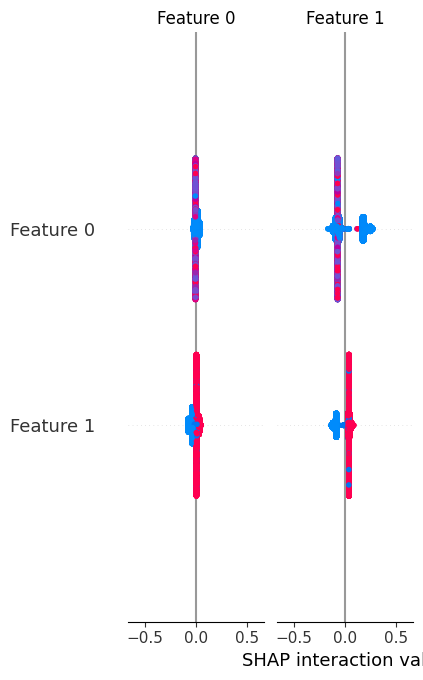

In [12]:
import shap

# Initialize SHAP explainer for RandomForest (TreeExplainer)
explainer = shap.TreeExplainer(best_rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_val_selected)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_val_selected)


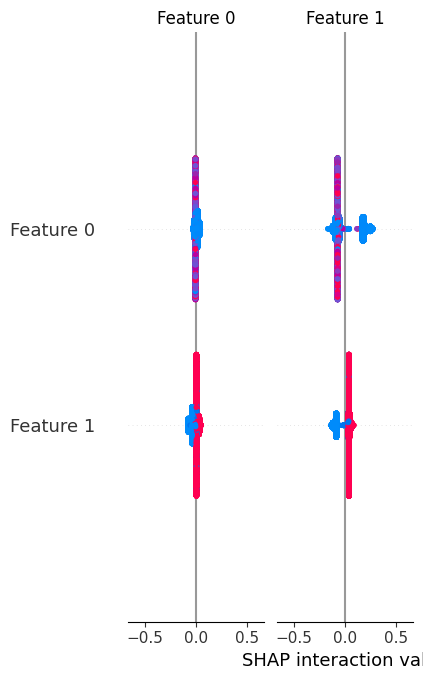

In [13]:
# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


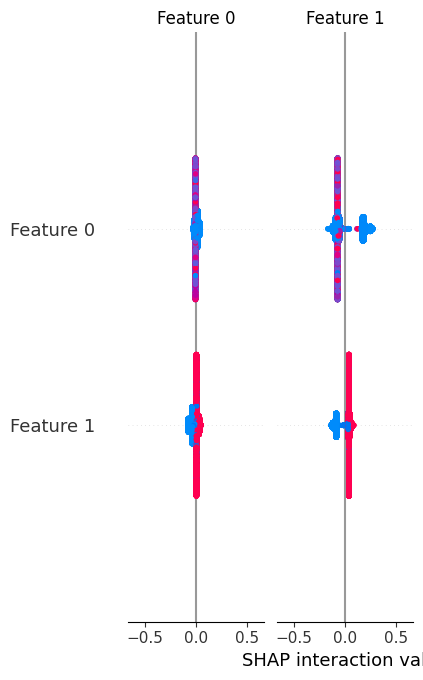

In [14]:
# SHAP Bar Plot for Feature Importance
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


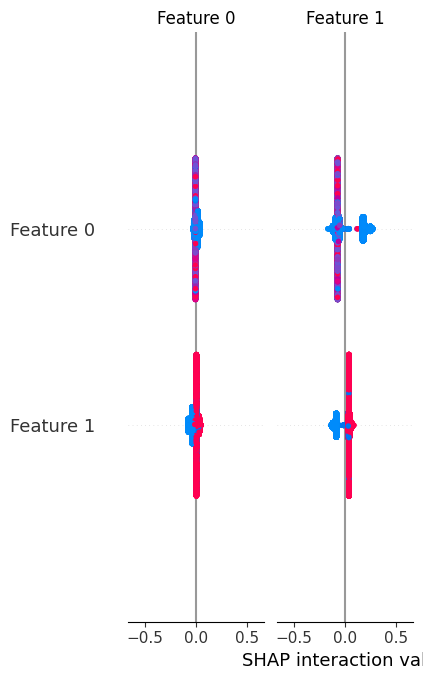

In [15]:
# SHAP Bar Plot for Feature Importance
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


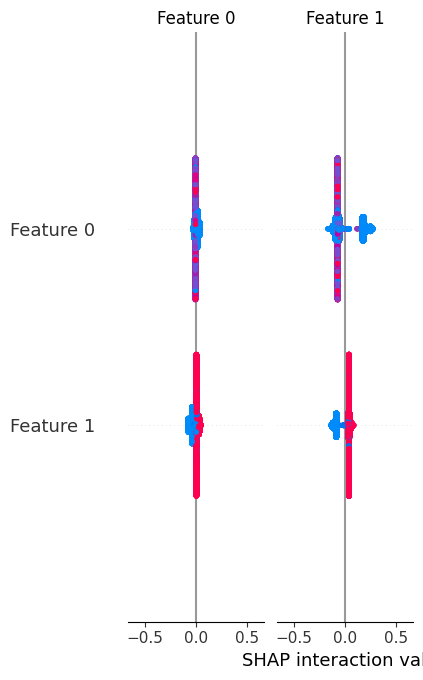

In [16]:
# SHAP Bar Plot for Feature Importance
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


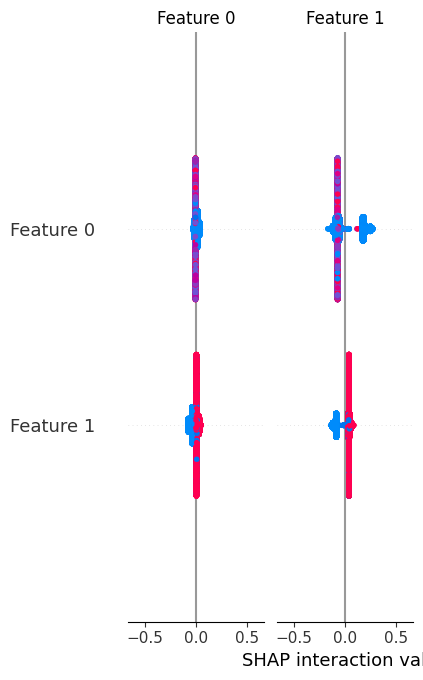

In [17]:
# SHAP Bar Plot for Feature Importance
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


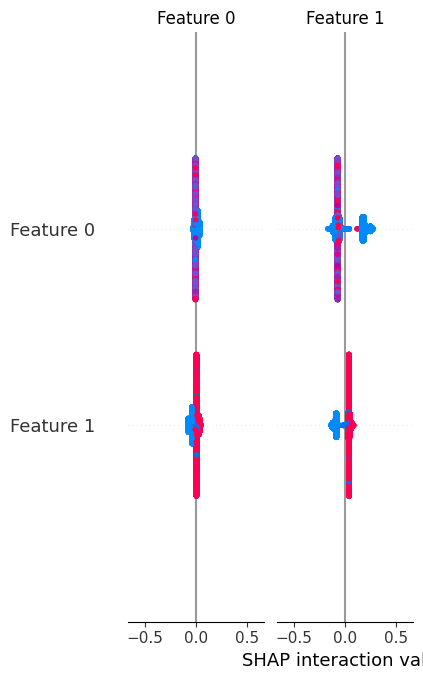

In [18]:
# SHAP Bar Plot for Feature Importance
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


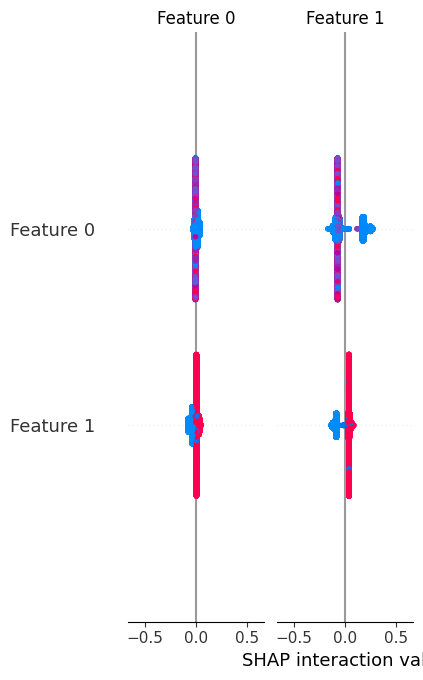

In [19]:
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


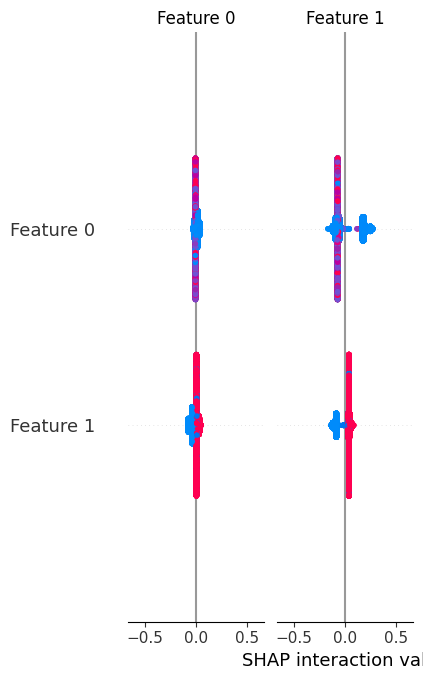

In [20]:
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


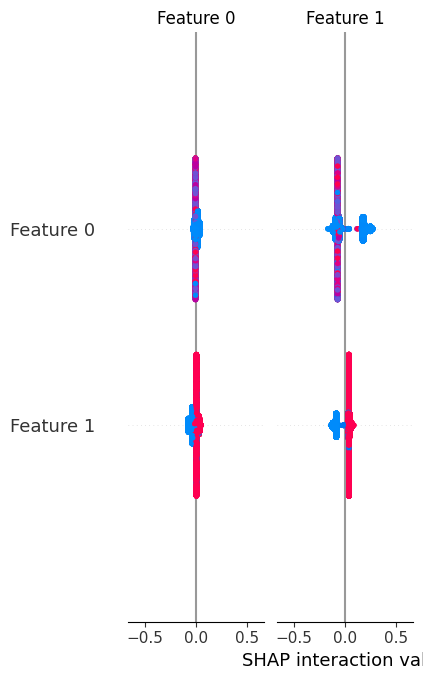

In [21]:
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


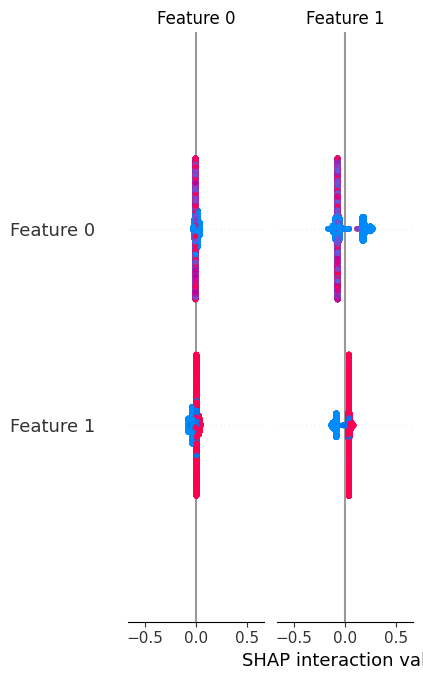

In [22]:
import shap

# Ensure you have shap_values and X_val_selected
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


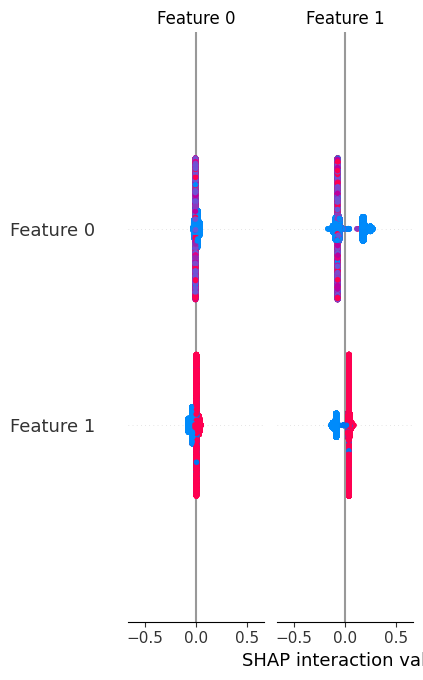

In [23]:
import shap

# Ensure correct SHAP values (not interaction values)
shap_values = explainer.shap_values(X_val_selected)

# Check if shap_values is a list (some models return multiple arrays)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use class 1 if it's a classification model

# Now generate the SHAP bar plot correctly
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


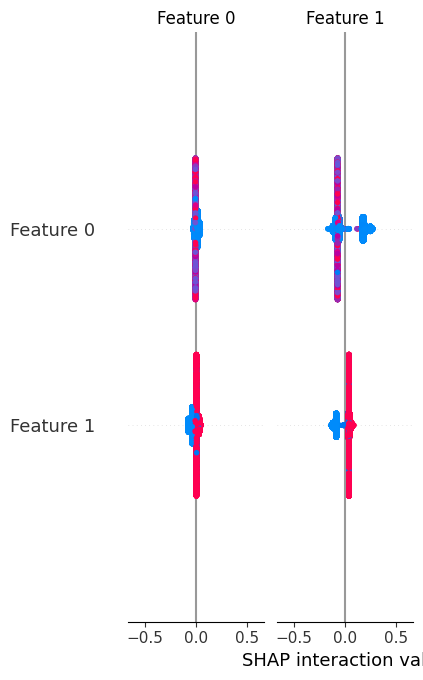

In [24]:
import shap

# Ensure correct SHAP values (not interaction values)
shap_values = explainer.shap_values(X_val_selected)

# If it's a list, select the correct class (for classification problems)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Change index based on your target class

# Now generate the correct SHAP bar plot
shap.summary_plot(shap_values, X_val_selected, plot_type="bar")


In [25]:
import numpy as np

# Check SHAP values
print("SHAP Values Type:", type(shap_values))
print("SHAP Values Shape:", np.shape(shap_values))


SHAP Values Type: <class 'numpy.ndarray'>
SHAP Values Shape: (35069, 20, 2)


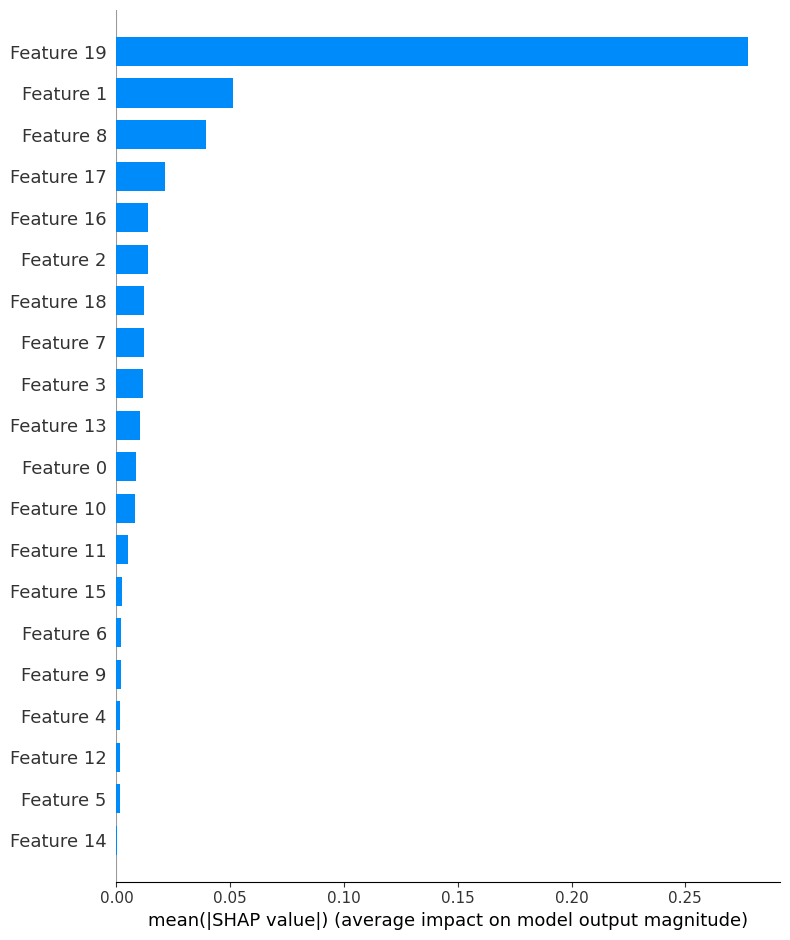

In [26]:
import shap

# Select SHAP values for class 1 (you can change to 0 if needed)
shap_values_class = shap_values[:, :, 1]

# Generate the bar plot
shap.summary_plot(shap_values_class, X_val_selected, plot_type="bar")


In [28]:
import pandas as pd

# Assuming X_val_selected was originally derived from a DataFrame
feature_names = pd.DataFrame(X_val_selected).columns
feature_names


RangeIndex(start=0, stop=20, step=1)

In [29]:
feature_names = X_train.columns  # or X_test.columns if applicable
feature_names


Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload',
       ...
       'attack_cat_Analysis', 'attack_cat_Backdoor', 'attack_cat_DoS',
       'attack_cat_Exploits', 'attack_cat_Fuzzers', 'attack_cat_Generic',
       'attack_cat_Normal', 'attack_cat_Reconnaissance',
       'attack_cat_Shellcode', 'attack_cat_Worms'],
      dtype='object', length=204)

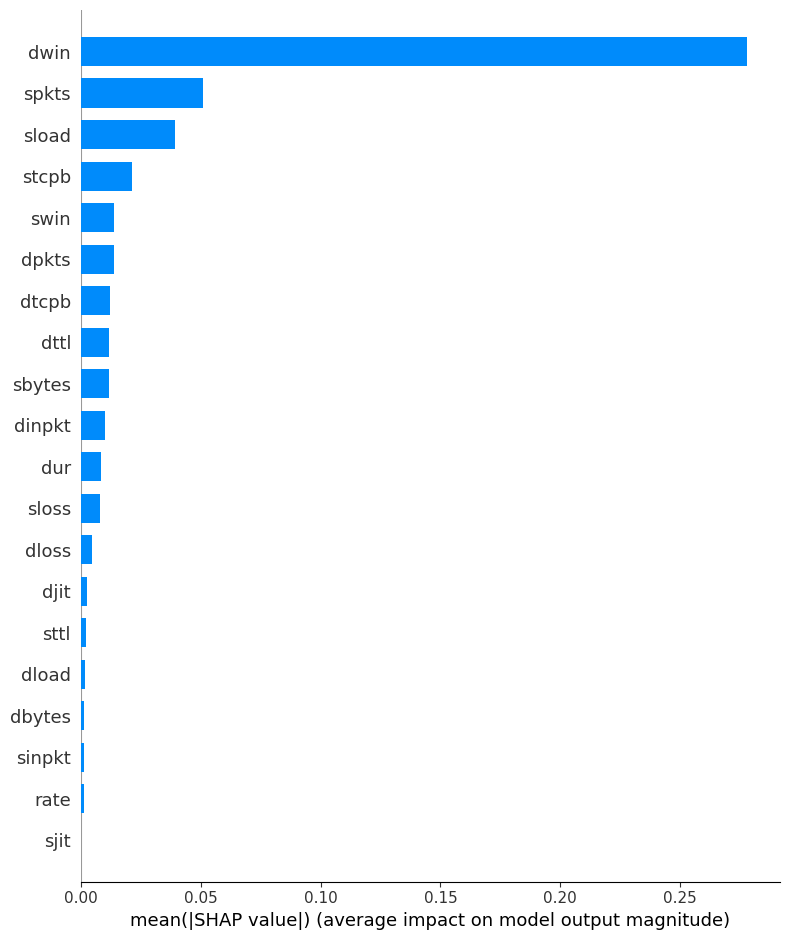

In [33]:
# Assuming 'X_train' was the original DataFrame before feature selection
feature_names = X_train.columns[:X_train_selected.shape[1]]

shap.summary_plot(shap_values_class, X_val_selected, plot_type="bar", feature_names=feature_names)


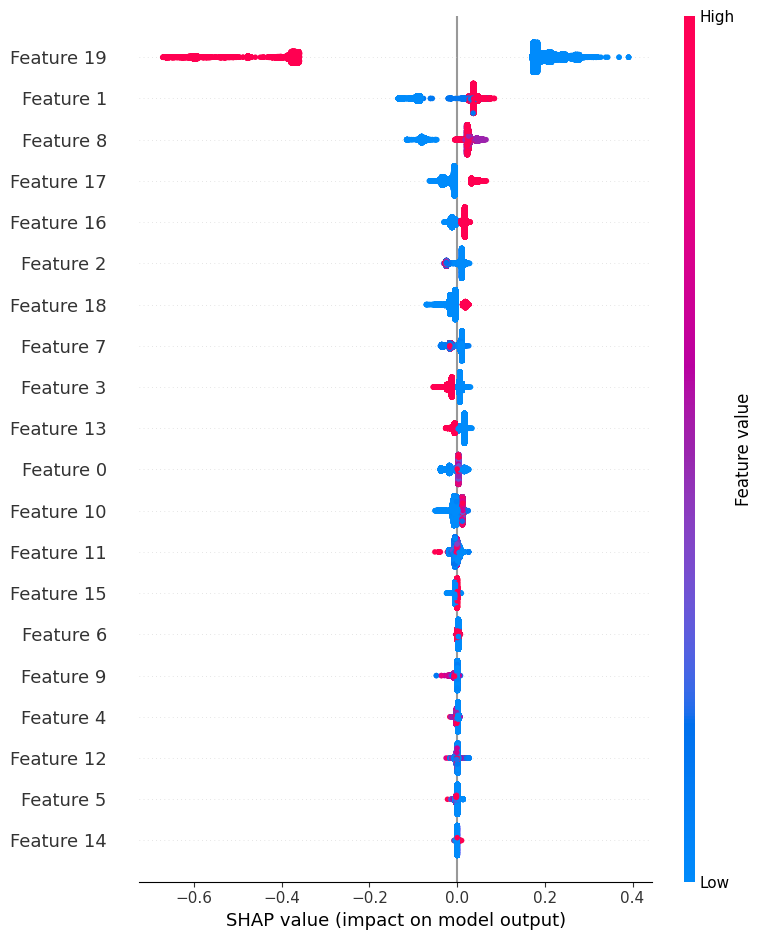

In [34]:
shap.summary_plot(shap_values_class, X_val_selected)


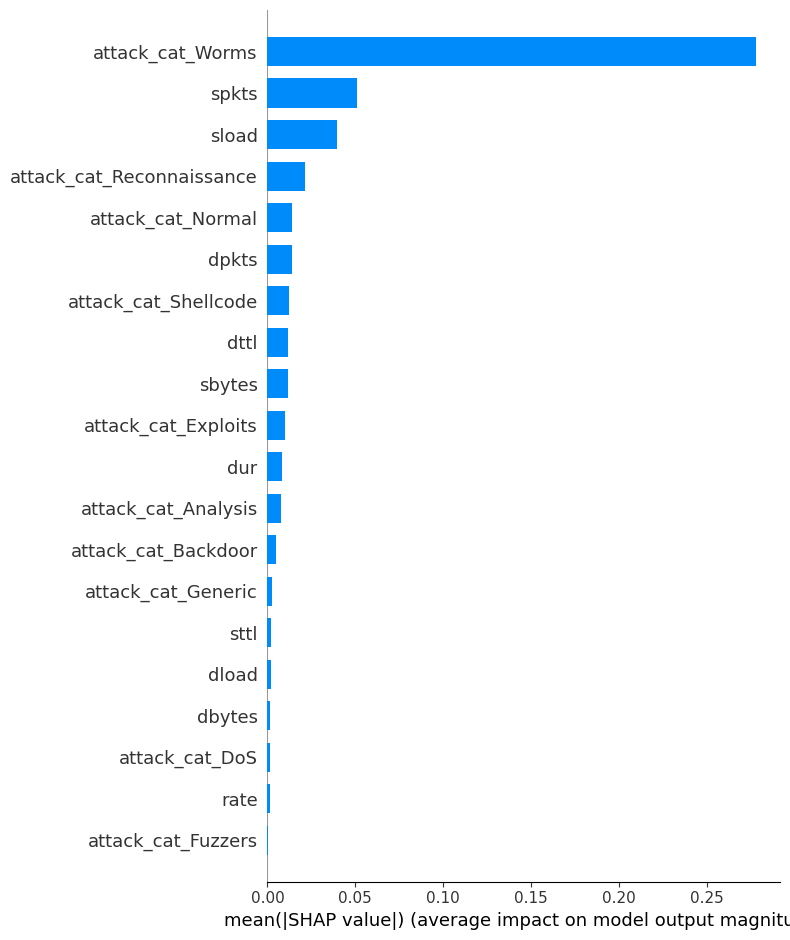

In [35]:
import pandas as pd

# Ensure feature names are correctly assigned
feature_names = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
                 'sload', 'dload', 'attack_cat_Analysis', 'attack_cat_Backdoor',
                 'attack_cat_DoS', 'attack_cat_Exploits', 'attack_cat_Fuzzers',
                 'attack_cat_Generic', 'attack_cat_Normal', 'attack_cat_Reconnaissance',
                 'attack_cat_Shellcode', 'attack_cat_Worms']

# Convert NumPy array to DataFrame
X_val_selected_df = pd.DataFrame(X_val_selected, columns=feature_names)

# Generate SHAP plot with feature names
shap.summary_plot(shap_values_class, X_val_selected_df, plot_type="bar", feature_names=feature_names)


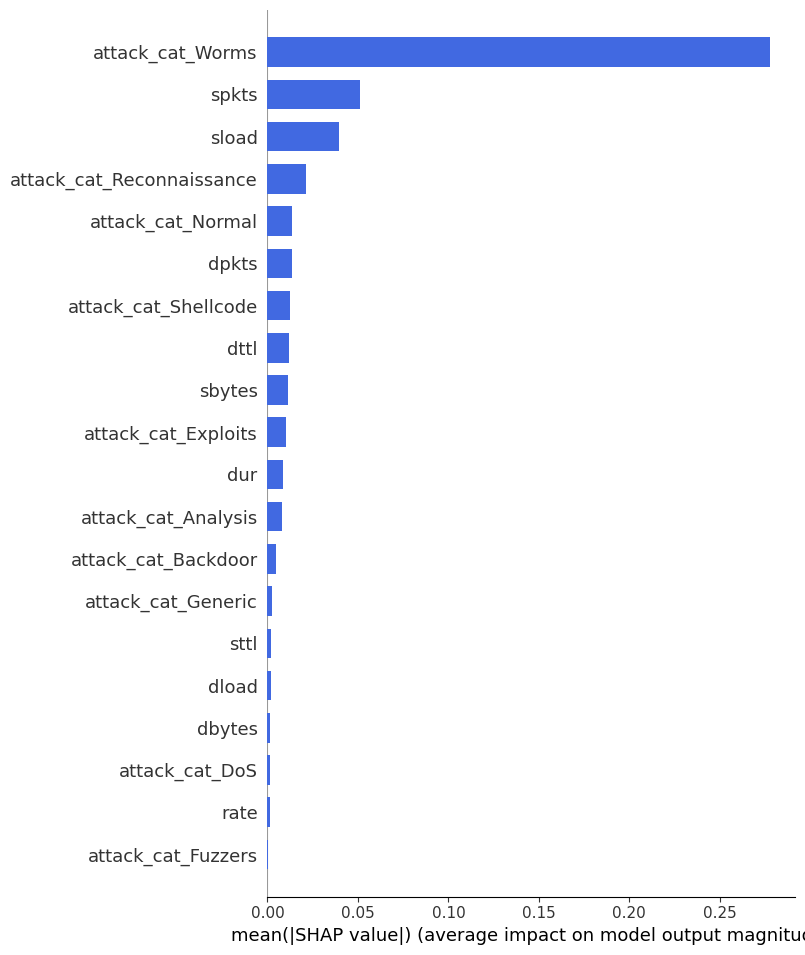

In [41]:
import shap
import matplotlib.pyplot as plt

# Set a larger font size for readability
plt.rcParams.update({'font.size': 5})

# Generate SHAP summary plot with improved layout
shap.summary_plot(
    shap_values_class,
    X_val_selected,
    plot_type="bar",
    feature_names=feature_names,
    color='royalblue'  # Custom color for bars
)


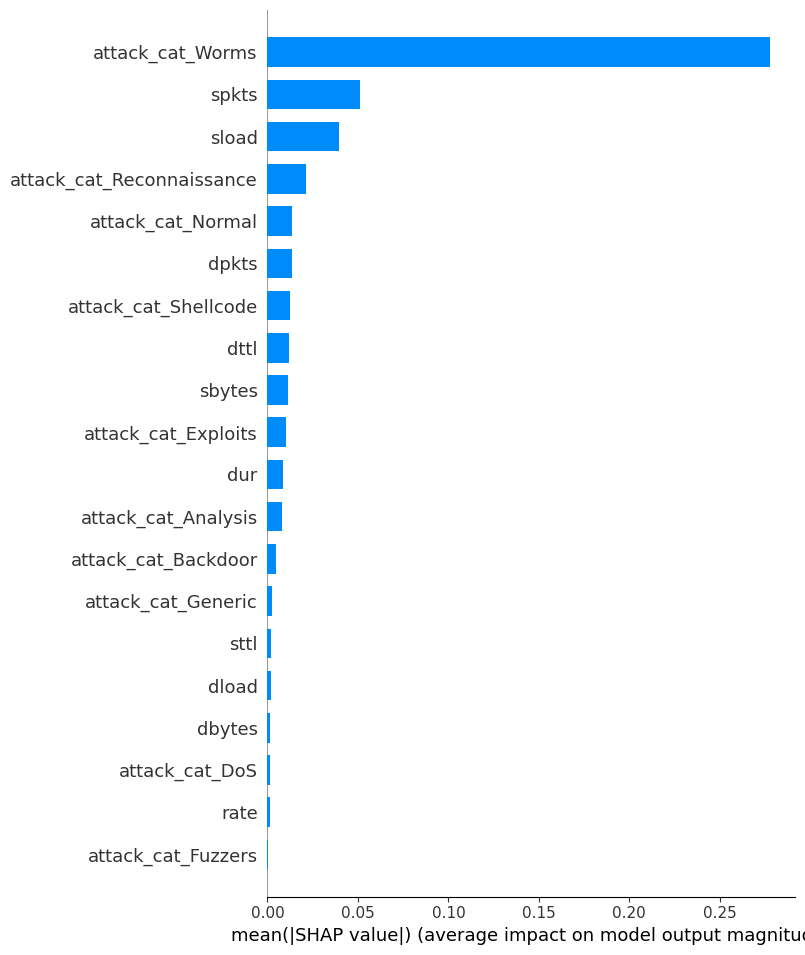

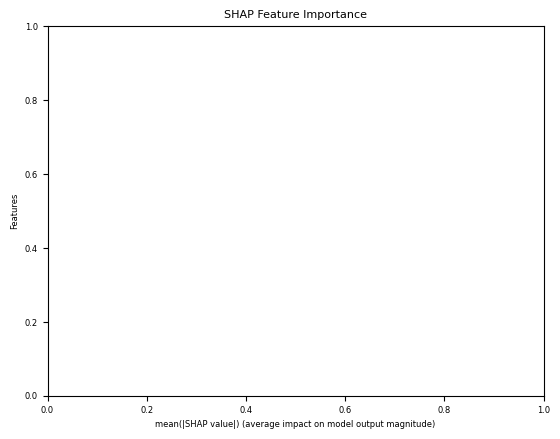

In [42]:
import shap
import matplotlib.pyplot as plt

# Set font size directly in the summary plot
plt.figure(figsize=(8, 6))  # Adjust figure size
shap.summary_plot(
    shap_values_class,
    X_val_selected,
    plot_type="bar",
    feature_names=feature_names
)

# Reduce font size for tick labels manually
plt.xticks(fontsize=6)  # Reduce x-axis font size
plt.yticks(fontsize=6)  # Reduce y-axis font size
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)", fontsize=6)
plt.ylabel("Features", fontsize=6)
plt.title("SHAP Feature Importance", fontsize=8)

plt.show()


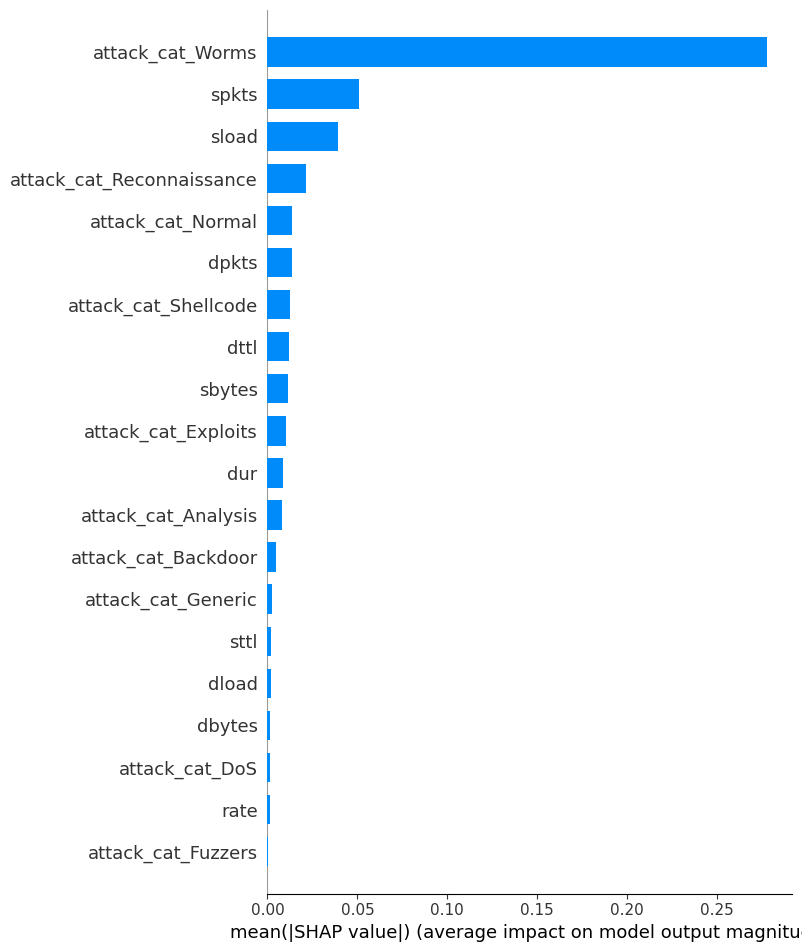

In [43]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 6})  # Set global font size
shap.summary_plot(shap_values_class, X_val_selected, plot_type="bar", feature_names=feature_names)


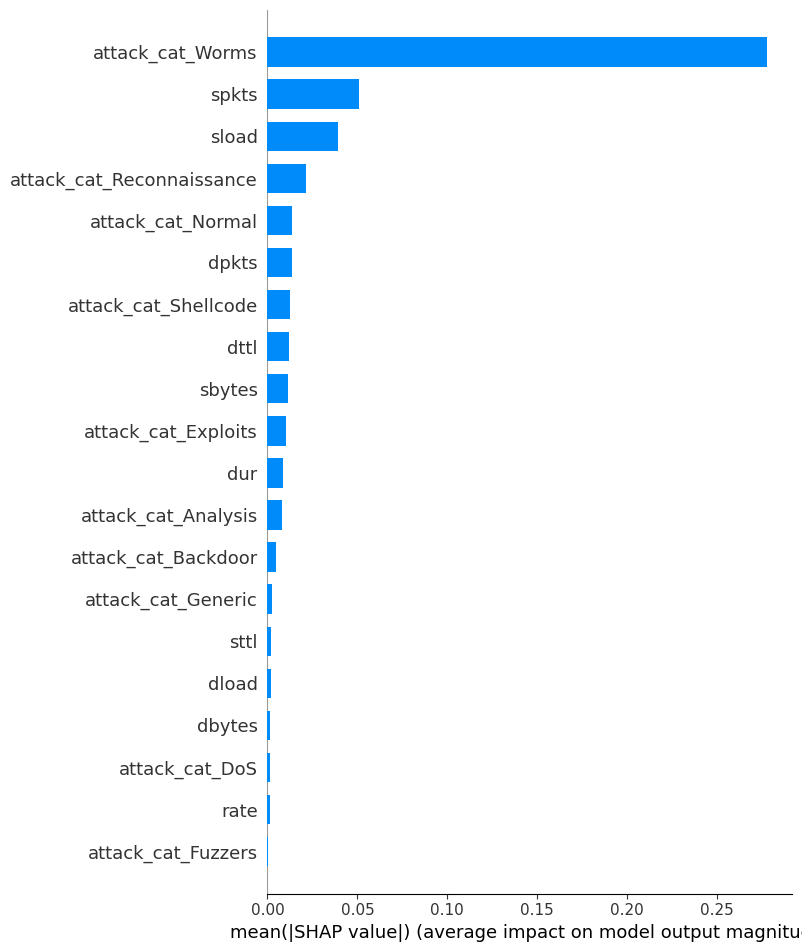

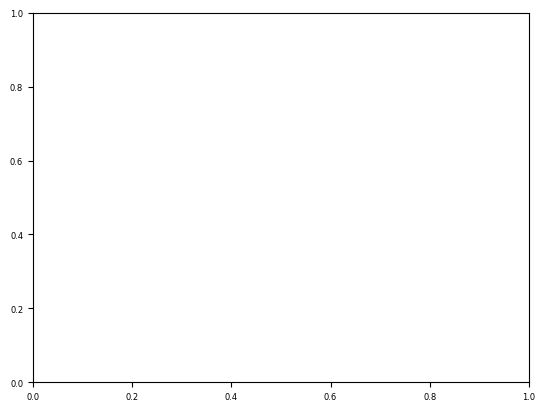

In [45]:
import matplotlib.pyplot as plt
import shap

# Reduce font size globally
plt.rcParams.update({'font.size': 6})  # Adjust as needed

# Create SHAP plot
shap.summary_plot(shap_values_class, X_val_selected, plot_type="bar", feature_names=feature_names)

# Explicitly set tick label size
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()


AssertionError: Feature and SHAP matrices must have the same number of rows!

<Figure size 600x400 with 0 Axes>

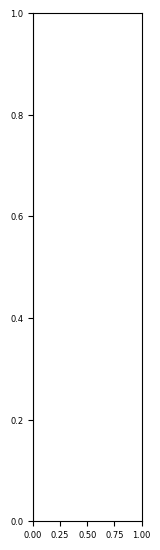

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # Adjust width and height as needed
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")


In [47]:
print(shap_values.shape)  # Check SHAP values shape
print(X_train_selected.shape)  # Check feature matrix shape


(35069, 20, 2)
(140272, 20)


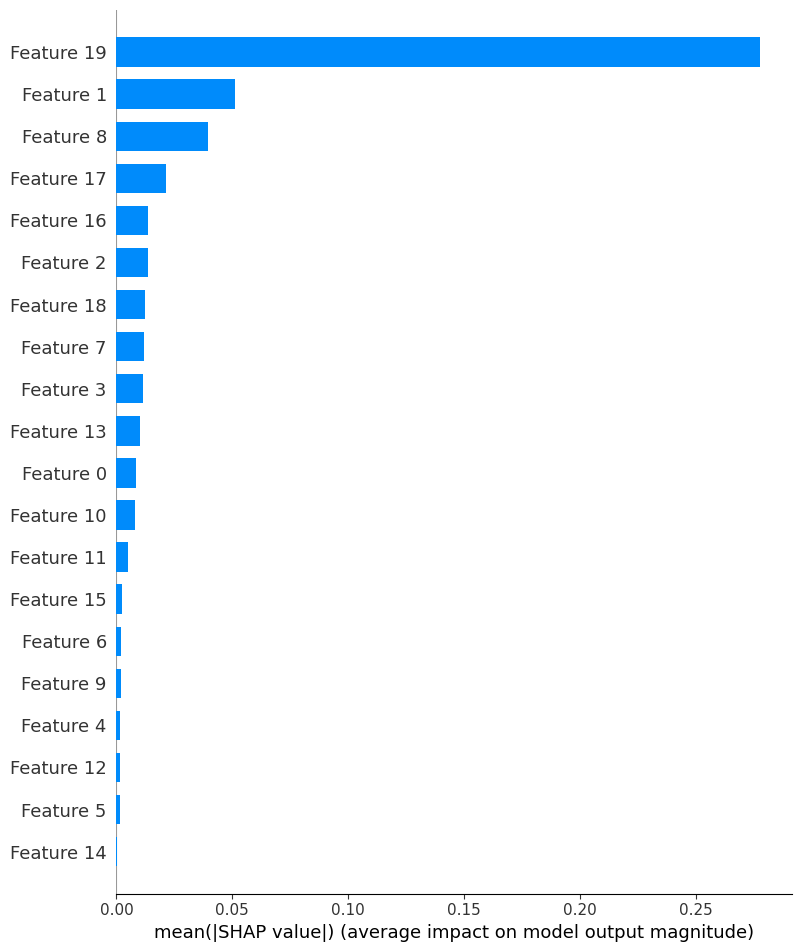

In [49]:
shap_values_class_0 = shap_values[:, :, 0]  # Extract SHAP values for the first class
shap.summary_plot(shap_values_class_0, X_train_selected, plot_type="bar")


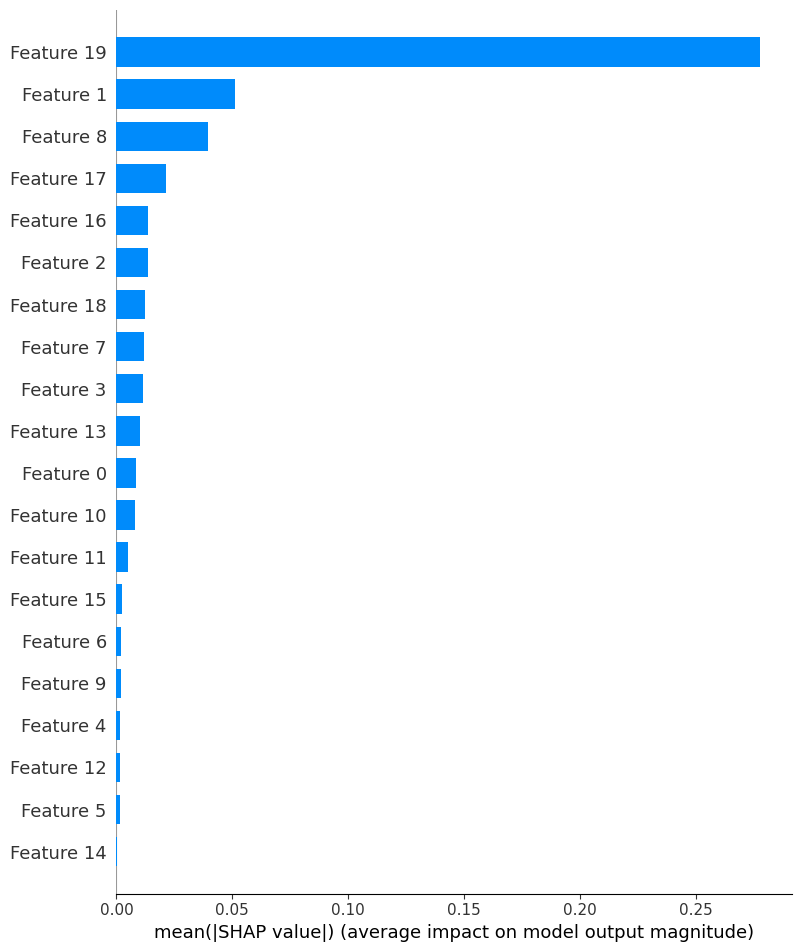

In [50]:
X_train_subset = X_train_selected[:35069]  # Match the row count
shap.summary_plot(shap_values_class_0, X_train_subset, plot_type="bar")


In [51]:
# Install necessary libraries
!pip install shap scikit-learn pandas matplotlib --quiet

# Import required libraries
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load dataset (Replace with your actual dataset file)
file_path = "/content/your_dataset.csv"  # Update this path
df = pd.read_csv(file_path)

# Preprocessing: Define Features and Target
target_column = "attack_type"  # Update with your target column name
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Generate SHAP summary plot
plt.figure(figsize=(6, 4))  # Adjust figure size if needed
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Save the plot
plt.savefig("shap_summary.png")

# Show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/your_dataset.csv'

In [52]:
import os

# List all files in /content
os.listdir('/content')


['.config',
 'UNSW_NB15_testing-set.csv',
 'UNSW_NB15_training-set.csv',
 'sample_data']

In [53]:
import pandas as pd

# Correct file paths (Replace with actual filenames)
train_file_path = "/content/UNSW_NB15_testing-set.csv"
test_file_path = "/content/UNSW_NB15_training-set.csv"

# Load the datasets
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Display the first few rows
df_train.head(), df_test.head()


(   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
 0   1  0.000011   udp       -   INT      2      0     496       0   
 1   2  0.000008   udp       -   INT      2      0    1762       0   
 2   3  0.000005   udp       -   INT      2      0    1068       0   
 3   4  0.000006   udp       -   INT      2      0     900       0   
 4   5  0.000010   udp       -   INT      2      0    2126       0   
 
           rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
 0   90909.0902  ...                 1               2             0   
 1  125000.0003  ...                 1               2             0   
 2  200000.0051  ...                 1               3             0   
 3  166666.6608  ...                 1               3             0   
 4  100000.0025  ...                 1               3             0   
 
    ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
 0           0                 0           1           2           

In [54]:
print("Missing values in train dataset:\n", df_train.isnull().sum().sum())
print("Missing values in test dataset:\n", df_test.isnull().sum().sum())


Missing values in train dataset:
 0
Missing values in test dataset:
 0


In [55]:
print(df_train.info())
print(df_test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [56]:
# Identify target column (replace 'target_column' with actual name)
target_column = "label"  # Change this to your actual target column name

# Define X (features) and y (target)
X_train = df_train.drop(columns=[target_column])
y_train = df_train[target_column]

X_test = df_test.drop(columns=[target_column])
y_test = df_test[target_column]

# Print shape of datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (82332, 44), y_train shape: (82332,)
X_test shape: (175341, 44), y_test shape: (175341,)


In [57]:
print(df_train.columns)


Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


In [59]:
# Identify non-numeric (categorical) columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_cols)


Categorical Columns: Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')


In [60]:
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Ensure both datasets have the same columns (avoid mismatch issues)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)


In [62]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_test:", X_test.columns)


Columns in X_train: Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload',
       ...
       'attack_cat_Analysis', 'attack_cat_Backdoor', 'attack_cat_DoS',
       'attack_cat_Exploits', 'attack_cat_Fuzzers', 'attack_cat_Generic',
       'attack_cat_Normal', 'attack_cat_Reconnaissance',
       'attack_cat_Shellcode', 'attack_cat_Worms'],
      dtype='object', length=201)
Columns in X_test: Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload',
       ...
       'attack_cat_Analysis', 'attack_cat_Backdoor', 'attack_cat_DoS',
       'attack_cat_Exploits', 'attack_cat_Fuzzers', 'attack_cat_Generic',
       'attack_cat_Normal', 'attack_cat_Reconnaissance',
       'attack_cat_Shellcode', 'attack_cat_Worms'],
      dtype='object', length=201)


In [63]:
print([col for col in X_train.columns if "proto" in col])


['proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nlsp', 'proto_iatp', 'proto_ib', 'proto_idpr', 'proto_idpr-cmtp', 'proto_idrp', 'proto_ifmp', 'proto_igmp', 'proto_igp', 'proto_il', 'proto_ip', 'proto_ipcomp', 'proto_ipcv', 'proto_ipip', 'proto_iplt', 'proto_ipnip', 'proto_ippc', 'proto_ipv6', 'proto_ipv6-frag', 'proto_ipv6-no', 'proto_ipv6-opts', 'proto_ipv6-route', 'proto_ipx-n-ip', 'proto_irtp', 'proto_isis', 'proto_iso-ip', 'proto_iso-tp4', 'proto_kryptolan', 'proto_l2tp', 'proto_larp', 'proto_leaf-1', 'proto_leaf-2', 'proto_merit-inp', '

In [64]:
if 'proto' in X_train.columns:
    le = LabelEncoder()
    X_train['proto'] = le.fit_transform(X_train['proto'])
    X_test['proto'] = le.transform(X_test['proto'])
else:
    print("Column 'proto' not found! Check dataset.")


Column 'proto' not found! Check dataset.


In [65]:
import pandas as pd

df_train = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
df_test = pd.read_csv('/content/UNSW_NB15_training-set.csv')

print(df_train.head())  # Check if 'proto' is present
print(df_test.head())


   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2                0   
1     

In [66]:
df_train['proto'] = df_train['proto'].astype(str)
df_test['proto'] = df_test['proto'].astype(str)

# One-hot encoding (or label encoding) can be applied here
df_train = pd.get_dummies(df_train, columns=['proto'])
df_test = pd.get_dummies(df_test, columns=['proto'])


In [69]:
print(df_train.columns)  # Check if 'proto' exists in the training dataset
print(df_test.columns)   # Check if 'proto' exists in the testing dataset


Index(['id', 'dur', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes',
       'rate', 'sttl',
       ...
       'proto_visa', 'proto_vmtp', 'proto_vrrp', 'proto_wb-expak',
       'proto_wb-mon', 'proto_wsn', 'proto_xnet', 'proto_xns-idp', 'proto_xtp',
       'proto_zero'],
      dtype='object', length=175)
Index(['id', 'dur', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes',
       'rate', 'sttl',
       ...
       'proto_visa', 'proto_vmtp', 'proto_vrrp', 'proto_wb-expak',
       'proto_wb-mon', 'proto_wsn', 'proto_xnet', 'proto_xns-idp', 'proto_xtp',
       'proto_zero'],
      dtype='object', length=177)


In [71]:
proto_columns = [col for col in df_train.columns if col.startswith('proto_')]
print(proto_columns)  # Check the list of proto-related columns


['proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nlsp', 'proto_iatp', 'proto_ib', 'proto_idpr', 'proto_idpr-cmtp', 'proto_idrp', 'proto_ifmp', 'proto_igmp', 'proto_igp', 'proto_il', 'proto_ip', 'proto_ipcomp', 'proto_ipcv', 'proto_ipip', 'proto_iplt', 'proto_ipnip', 'proto_ippc', 'proto_ipv6', 'proto_ipv6-frag', 'proto_ipv6-no', 'proto_ipv6-opts', 'proto_ipv6-route', 'proto_ipx-n-ip', 'proto_irtp', 'proto_isis', 'proto_iso-ip', 'proto_iso-tp4', 'proto_kryptolan', 'proto_l2tp', 'proto_larp', 'proto_leaf-1', 'proto_leaf-2', 'proto_merit-inp', '

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Load the datasets
train_path = "/content/UNSW_NB15_training-set.csv"  # Update if needed
test_path = "/content/UNSW_NB15_testing-set.csv"  # Update if needed

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Drop unnecessary columns
df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

# Define features and target
X_train = df_train.drop(columns=['label', 'attack_cat'])
y_train = df_train['label']
X_test = df_test.drop(columns=['label', 'attack_cat'])
y_test = df_test['label']

# Handle categorical features (skip if already encoded)
categorical_cols = ['service', 'state']
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Ensure train & test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print(f"Final X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")


Final X_train shape: (175341, 62)
Final X_test shape: (82332, 62)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Load the datasets
train_path = "/content/UNSW_NB15_training-set.csv"  # Update if needed
test_path = "/content/UNSW_NB15_testing-set.csv"  # Update if needed

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Drop unnecessary columns
df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

# Define features and target
X_train = df_train.drop(columns=['label', 'attack_cat'])
y_train = df_train['label']
X_test = df_test.drop(columns=['label', 'attack_cat'])
y_test = df_test['label']

# Handle categorical features
categorical_cols = ['service', 'state', 'proto']
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Ensure train & test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print(f"Final X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")

# Use RandomForestClassifier for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE to select top 20 features
selector = RFE(rf, n_features_to_select=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X_train.columns[selector.support_]
print(f"Selected Features: {selected_features}")

Final X_train shape: (175341, 194)
Final X_test shape: (82332, 194)
